In [1]:
# coding: utf-8
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

import os
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)

import sys
sys.path.append(current_dir)

import weth_api as wa
import gpt


In [2]:
# getting credles
forecast_settings = wa.read_yaml_config('config.yaml', section='api.weatherapi.com')
base_url = forecast_settings['url']
method = forecast_settings['method']
forecast_api_key = forecast_settings['api_key']

gpt_settings = wa.read_yaml_config('config.yaml', section='gpt')
gpt_api_key = gpt_settings['api_key']

In [4]:
# getting weahter forecast for current place for nearest day hourly
gwd = wa.get_weth_data(forecast_api_key, base_url, method, '36.757594, 31.45268', 7)
df = wa.load_weth_data_to_df(gwd)

In [5]:
df.sample(3)

,time,is_day,temp_c,feelslike_c,windchill_c,heatindex_c,condition,wind_kph,wind_dir,pressure_hg,precip_mm,humidity,cloud,will_it_rain,will_it_snow,chance_of_rain,chance_of_snow,uv,place,region,country,lat,lon
12,2024-07-27 12:00:00,1,34.6,36.7,34.6,36.7,Sunny,6.5,WSW,753.061930,0.0,38,0,0,0,0,0,8.0,Manavgat,Antalya,Turkey,36.76,31.45
8,2024-07-24 08:00:00,1,31.1,35.0,31.2,35.0,Sunny,9.7,S,750.811745,0.0,58,3,0,0,0,0,8.0,Manavgat,Antalya,Turkey,36.76,31.45
20,2024-07-26 20:00:00,1,27.9,31.4,27.9,31.4,Sunny,6.5,WSW,751.561806,0.0,75,8,0,0,0,0,7.0,Manavgat,Antalya,Turkey,36.76,31.45


In [6]:
df['time'].values[0]

numpy.datetime64('2024-07-24T00:00:00.000000000')

In [15]:
work_df = df[
    (df['time'] >= np.datetime64('2024-07-24T16:00:00.000000000')) &
    (df['time'] < np.datetime64('2024-07-24T20:00:00.000000000'))
]
work_df['hour'] = work_df['time'].dt.hour

/tmp/ipykernel_74007/2171614536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_df['hour'] = work_df['time'].dt.hour


In [13]:
def linear(x, k, b, c) -> float:
    """
    Просто прямая

    Параметры:
    x (int or float): переменная
    k,b,c (int or float): параметры функции

    Возвращает:
    значение функции y = f(x)
    """
    return k * x + b

In [100]:
def calc_trends(work_df, x, y):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(linear, work_df[x], work_df[y], 
                        # bounds=[0, np.inf],
                        method='trf',  #'lm', 'trf', 'dogbox'
                        )
    res = ''
    if popt[0] >= 0.05:
        res = 1 
    elif popt[0] <= -0.05:
        res = -1
    else:
        res = 0
    return res
def calc_metric(work_df, x, y):
    min = np.min(work_df[y])
    max = np.max(work_df[y])
    mean = np.mean(work_df[y])
    trend = calc_trends(work_df, x, y)

    if trend == 1:
        trend_rus = 'вырастет'
    elif trend == -1:
        trend_rus = 'уменьшится'
    else:
        trend_rus = 'практически не изменится'

    txt = "В ближайшее время " + y + " будет " + str(mean) + ": " + trend_rus + " с " + str(min) + " до " + str(max) 

    return txt

In [101]:
calc_metric(work_df, 'hour', 'humidity')

'В ближайшее время humidity будет 67.25: вырастет с 63 до 74'

In [85]:
calc_trends(work_df, 'hour', 'pressure_hg')

0

In [86]:
calc_trends(work_df, 'hour', 'feelslike_c')

-1

In [87]:
calc_trends(work_df, 'hour', 'humidity')

1

In [82]:
work_df['humidity']

16    63
17    65
18    67
19    74
Name: humidity, dtype: int64

<Axes: xlabel='hour'>

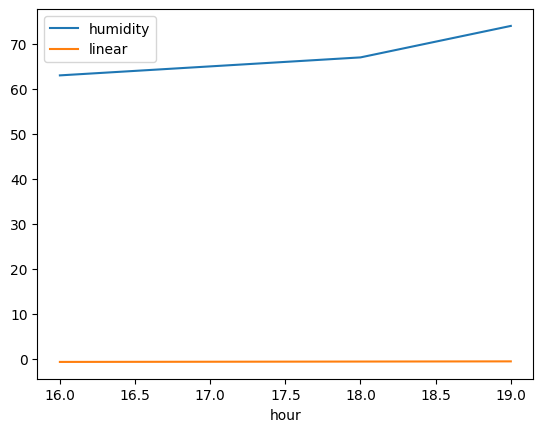

In [79]:
work_df.set_index('hour')[['humidity', 'linear']].plot()

In [47]:
work_df

,time,is_day,temp_c,feelslike_c,windchill_c,heatindex_c,condition,wind_kph,wind_dir,pressure_hg,precip_mm,humidity,cloud,will_it_rain,will_it_snow,chance_of_rain,chance_of_snow,uv,place,region,country,lat,lon,hour,linear
16,2024-07-24 16:00:00,1,31.0,35.8,31.0,35.8,Sunny,13.3,SSE,750.061683,0.0,63,0,0,0,0,0,8.0,Manavgat,Antalya,Turkey,36.76,31.45,16,44.499925
17,2024-07-24 17:00:00,1,30.5,35.0,30.5,35.0,Sunny,12.6,SSE,750.061683,0.0,65,0,0,0,0,0,8.0,Manavgat,Antalya,Turkey,36.76,31.45,17,43.669929
18,2024-07-24 18:00:00,1,30.0,34.3,30.0,34.3,Sunny,10.8,SSE,750.061683,0.0,67,0,0,0,0,0,7.0,Manavgat,Antalya,Turkey,36.76,31.45,18,42.839934
19,2024-07-24 19:00:00,1,28.4,32.3,28.4,32.3,Sunny,7.9,SSE,750.061683,0.0,74,0,0,0,0,0,7.0,Manavgat,Antalya,Turkey,36.76,31.45,19,42.009938


In [5]:
# reading the request from the file
with open('request.txt', 'r') as f:
    message = f.read()

In [6]:
# sending requests to model and saving answer to file
answ = gpt.send_message(gpt_api_key, message, model='gpt-4o')
with open('output.txt', 'w') as f:
    f.write(answ)
    f.close()